# Quite simple knn model

**A model designed to reach 97% accuracy on mnist dataset**

In [1]:
from sklearn.datasets import fetch_openml

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

mnist = fetch_openml('mnist_784', version=1)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
print(f'{X.shape = }')
print(f'{y.shape = }')

X.shape = (70000, 784)
y.shape = (70000,)


(-0.5, 27.5, 27.5, -0.5)

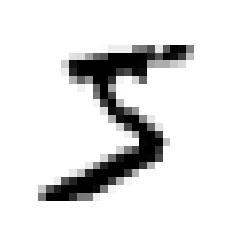

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Now let's find parameters for highest accuracy using GridSearch.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [4, 6, 8]}
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, scoring='accuracy', cv=3, return_train_score=True)

In [11]:
%%time
#grid_search.fit(X_train, y_train)
grid_search.fit(X_train[:20000], y_train[:20000]) # for acceptable time

Wall time: 1h 55min 20s


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [4, 6, 8],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy')

In [12]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [13]:
best_model = grid_search.best_estimator_
best_model

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [14]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.9485999522406118 {'n_neighbors': 4, 'weights': 'uniform'}
0.9530499847644881 {'n_neighbors': 4, 'weights': 'distance'}
0.9488499247404866 {'n_neighbors': 6, 'weights': 'uniform'}
0.9525499947624881 {'n_neighbors': 6, 'weights': 'distance'}
0.9463999497294862 {'n_neighbors': 8, 'weights': 'uniform'}
0.9504999847517374 {'n_neighbors': 8, 'weights': 'distance'}


In [15]:
%time y_pred = best_model.predict(X_test)

Wall time: 5min 8s


In [16]:
acc_best_model = sum(y_test == y_pred) / len(y_test)
acc_best_model

0.9589

Almost 96%, not bad, but can we get more?

Let's look for improvement in data augmentation.

In [17]:
from scipy.ndimage.interpolation import shift

In [18]:
def augment_mnist(X, y):
    X_augmented = list(X)
    y_augmented = list(y)
    
    for i, x in enumerate(X):
        x = x.reshape(28, 28)
        X_augmented.append(shift(x, [0, 1], cval=0).flatten())
        X_augmented.append(shift(x, [0, -1], cval=0).flatten())
        X_augmented.append(shift(x, [1, 0], cval=0).flatten())
        X_augmented.append(shift(x, [-1, 0], cval=0).flatten())
        
        y_augmented.extend([y[i]]*4)
        
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    perm = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[perm]
    y_augmented = y_augmented[perm]
    
    return X_augmented, y_augmented

In [19]:
%%time
X_augmented, y_augmented = augment_mnist(X_train, y_train)

Wall time: 36.3 s


In [20]:
from sklearn.base import clone
final_model = clone(best_model)

In [21]:
%time final_model.fit(X_augmented, y_augmented)

Wall time: 3min


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [22]:
%time y_augmented_pred = final_model.predict(X_test)

Wall time: 1h 18min 43s


In [23]:
acc_after_augmentation = sum(y_test == y_augmented_pred) / len(y_test)
acc_after_augmentation

0.9763

In [24]:
print(f'{acc_best_model = }')
print(f'{acc_after_augmentation = }')

acc_best_model = 0.9589
acc_after_augmentation = 0.9763


**Good. Data augmentation helped the model reach the goal.**

However, as for knn, it takes much time to make predictions for the model.

In [25]:
import joblib

joblib.dump(final_model, "saved_models\mnist_best_knn.pkl")

['saved_models\\mnist_best_knn.pkl']